# Linear regression with Tensorflow

In this project I would like to implement a linear regression with Tensorflow. I will use the data from the first project in Udacity Deep Learning Fundation Nanodegree.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
rng = np.random

# Load and prepare the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the cnt column. You can see the first few rows of the data above.



In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


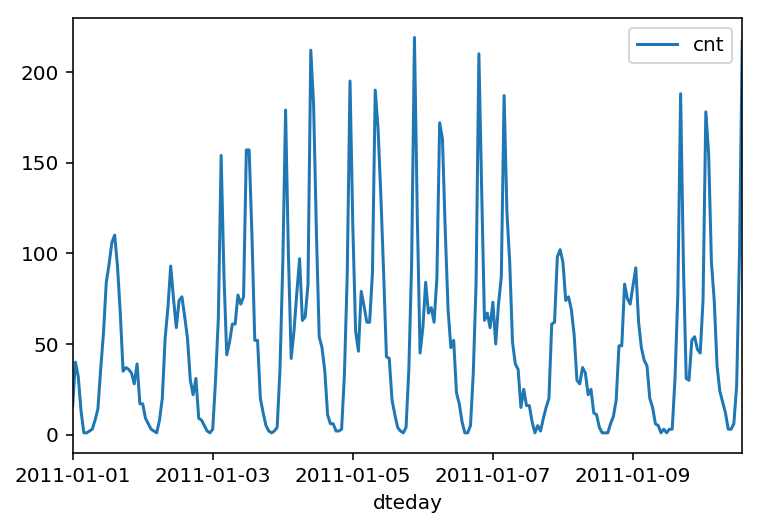

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables

Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to get_dummies().


In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [7]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
data.shape

(17379, 59)

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [10]:
training_data = data.sample(frac=0.8,random_state=200)
test_data = data.drop(training_data.index)

# save the data approximately the last 21 days
#test_data = data[-21*24:]

# remove the test data from the data set
#training_data = data[:-21*24]

# separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

train_features, train_targets = training_data.drop(target_fields, axis=1), training_data[target_fields]
X_test, y_test = test_data.drop(target_fields, axis=1).values, test_data['cnt'].values

In [11]:
train_features.shape

(13903, 56)

In [12]:
y_test.shape

(3476,)

# Build the network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$

In [62]:
# Parametres

epochs = 700
batch_size = 128
display_step = 200
learning_rate = 0.1

n_hidden = 20
n_output = 1
n_input = train_features.shape[1]

n_samples = train_features.shape[0]

In [63]:
tf.reset_default_graph()

# tf graph input
inputs = tf.placeholder("float", [None, n_input])
targets = tf.placeholder("float")

# set model weights
weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_output]))
}
biases = {
    'h1': tf.Variable(tf.truncated_normal([n_hidden])),
    'out': tf.Variable(tf.truncated_normal([n_output]))
}

In [64]:
# Create the model

def neural_net(x):
    # Hidden fully connected layer and sigmoid activation function
    layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['h1']))
    
    # Output fully connected layer
    layer_out = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])
    
    return layer_out

In [65]:
pred = neural_net(inputs)

# Mean squared error
cost = tf.reduce_mean(tf.square(pred-targets))

# Define loss and optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize the variable
init = tf.global_variables_initializer()

In [66]:
import sys

# Start training
with tf.Session() as sess:
    sess.run(init)
    losses = []
    for epoch in range(epochs):
        
        # mini-batching
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
        
        _, loss = sess.run([optimizer, cost], feed_dict={inputs: X, targets: y})
        
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * epoch/float(epochs)) \
                     + "% ... Training loss: " + str(loss)[:5])
        sys.stdout.flush()
        losses.append(loss)
        
    pred_y = sess.run(pred, feed_dict={inputs: X_test})
    pred_y = tf.transpose(pred_y)
    mse = tf.reduce_mean(tf.square(pred_y - y_test))
    print("\nMSE: {}".format(sess.run(mse)))

Progress: 99.9% ... Training loss: 0.985
MSE: 0.9932880401611328


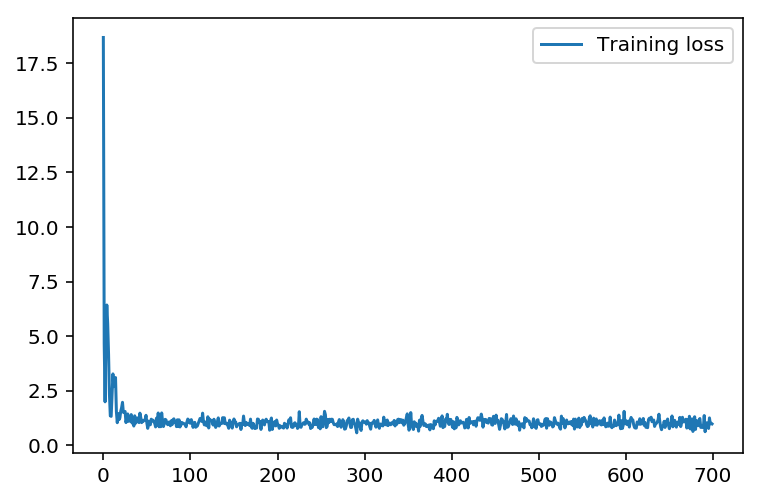

In [67]:
plt.plot(losses, label='Training loss')
plt.legend()
_ = plt.ylim()